# Imports

In [1]:
import tensorflow as tf
import matplotlib as plt
import matplotlib.pyplot
import numpy as np
import pandas as pd
import os
import pathlib
import PIL
import scipy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Sequential
import gc
from tensorflow.keras import backend as k
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU
from tensorflow.keras.callbacks import Callback

### Load data and get file path

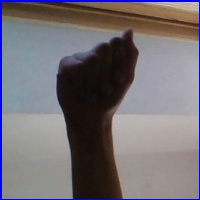

In [63]:
data_path = 'D:\CSP400/CSP400_ASLToText/Data/archive/asl_alphabet_train/asl_alphabet_train/'

data_dir = pathlib.Path(data_path)

data_path2 = 'D:\CSP400/CSP400_ASLToText/Data/archive/asl_alphabet_test/asl_alphabet_test/'

data_dir2 = pathlib.Path(data_path2)

A = list(data_dir.glob('A/*'))
image_count = len(A)
PIL.Image.open(str(A[0]))

### Splitting data into train and validation datasets

In [3]:
batch_size = 16
img_height = 200
img_width = 200

#train_ds = tf.keras.utils.image_dataset_from_directory(
#    data_dir,
#    validation_split=0.2,
#    subset="training",
#    seed=123,
#    image_size=(img_height, img_width),
#    batch_size=batch_size)
#
#val_ds = tf.keras.utils.image_dataset_from_directory( 
#    data_dir,
#    validation_split=0.2,
#    subset="validation",
#    seed=123,
#    image_size=(img_height, img_width),
#    batch_size=batch_size)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


#### Generator instead of image_dataset_from_directory.

In [61]:
batch_size = 16
img_height = 200
img_width = 200

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(200, 200),
    batch_size=16,
    subset="training",
    class_mode="categorical",
    shuffle=True,
    color_mode="rgb"
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(200, 200),
    batch_size=16,
    subset="validation",
    class_mode="categorical",
    shuffle=True,
    color_mode="rgb"
)

test_generator = test_datagen.flow_from_directory(
    data_dir2,
    target_size=(200, 200),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
)

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


### Display some of the data

In [64]:
class_names = train_generator.classes
label_map = (train_generator.class_indices)
print(label_map)


#plt.pyplot.figure(figsize=(10, 10))
#for images, labels in train_ds.take(1):
#  for i in range(9):
#    ax = plt.pyplot.subplot(3, 3, i + 1)
#    plt.pyplot.imshow(images[i].numpy().astype("uint8"))
#    plt.pyplot.title(class_names[labels[i]])
#    plt.pyplot.axis("off")

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = datagen.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = datagen.cache().prefetch(buffer_size=AUTOTUNE)

AttributeError: 'ImageDataGenerator' object has no attribute 'cache'

In [6]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


#### Resnet model

In [65]:
#num_classes = len(class_names)
#
#model = tf.keras.applications.resnet50.ResNet50(
#    include_top=False,
#    weights=None,
#    input_tensor=None,
#    input_shape=(200,200,3),
#    pooling=None,
#    classes=num_classes,)
#
#model.compile(optimizer='adam',
#              loss='categorical_crossentropy',
#              metrics=['accuracy'],
#              #run_eagerly=True
#                )
#              
#model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_12[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

#### Basic model.

In [70]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              run_eagerly=True)
              
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 100, 100, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 50, 50, 64)       

In [71]:
#class ClearMemory(Callback):
#    def on_epoch_end(self, epoch, logs=None):
#        gc.collect()
#        k.clear_session()

model = prepare_model()

epochs = 50

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

#history = model.fit(
#  train_generator,
#  epochs=50,
#  validation_data=validation_generator,
#  batch_size=16
#)

Epoch 1/10


C:\Users\cyan1\AppData\Local\Temp\ipykernel_10756\3333094982.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator,


ValueError: Shapes (16, 29) and (16, 69600) are incompatible